In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import glob
import re
import seaborn as sns
import tensorflow as tf
import transformers
from transformers import TFBertForTokenClassification
from tqdm.notebook import tqdm
from scipy.stats import pearsonr

import sys
sys.path.append("..")
from data_preparation.data_preparation_pos import ABSATokenizer, convert_examples_to_tf_dataset, read_conll
import utils.utils as utils
import utils.pos_utils as pos_utils
import utils.postprocessing_utils as post_utils

#<img src="attachment:image.png" width="300" height="300" align="left">
"""
<hr>
<a id=""></a>

[Back to contents](#index)
""";

<a id="index"></a>

[A.1. Lang vs Group Accuracy](#A1)

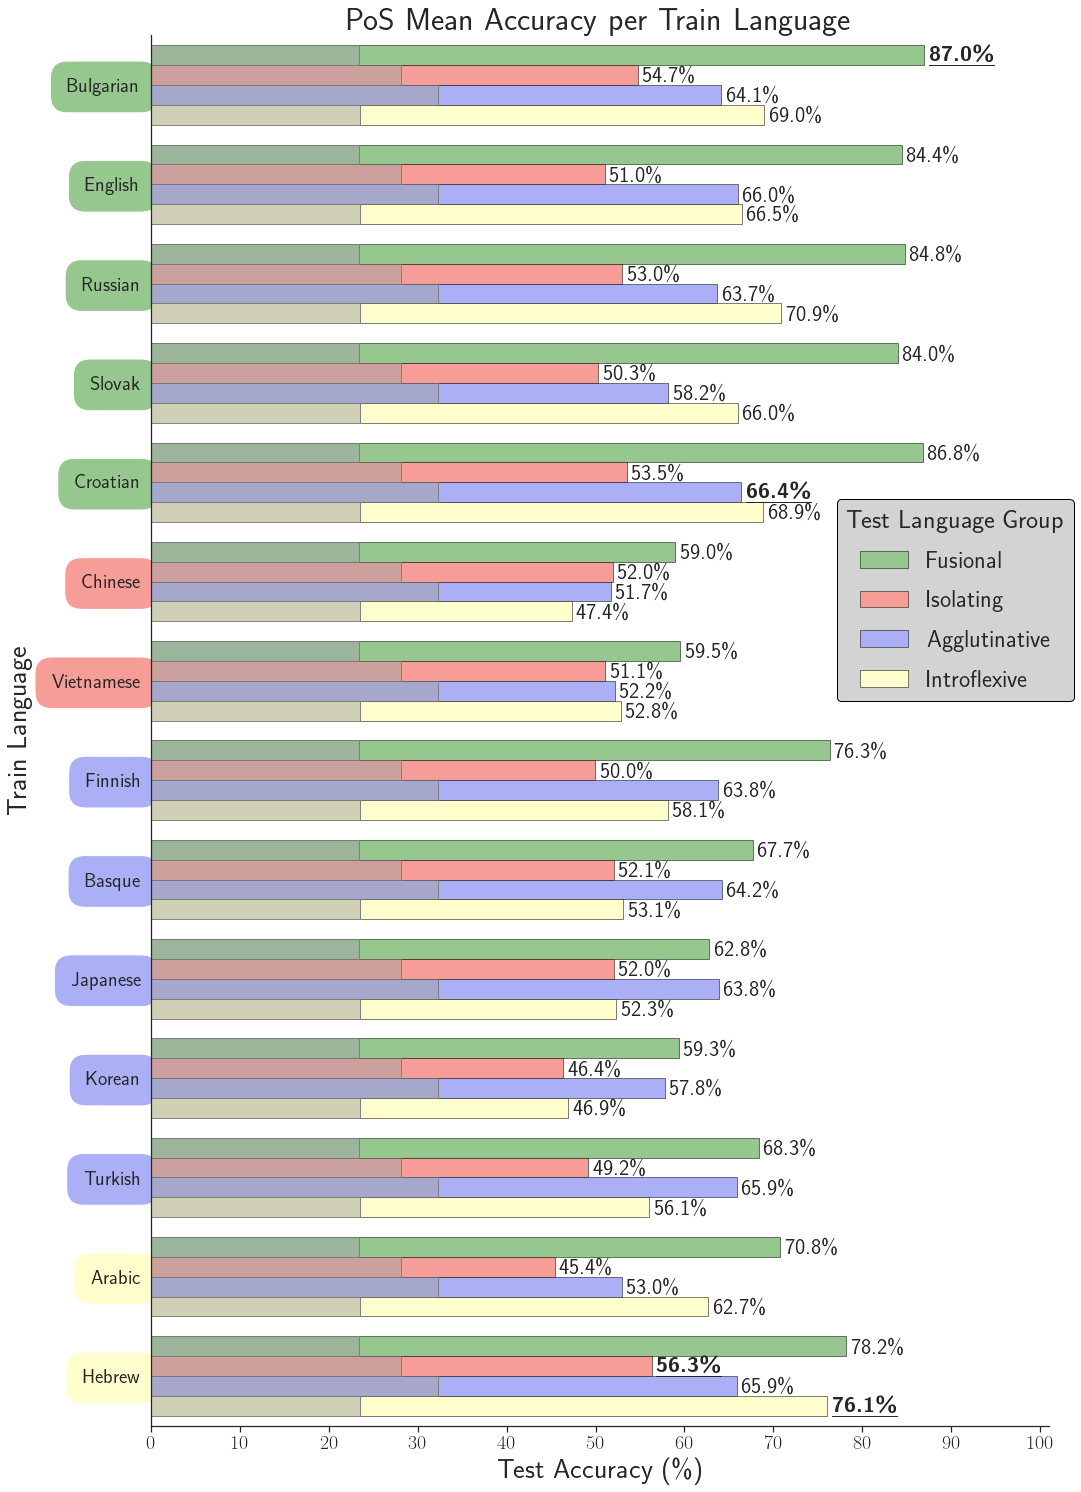

[A.2. Group vs Group Accuracy](#A2)

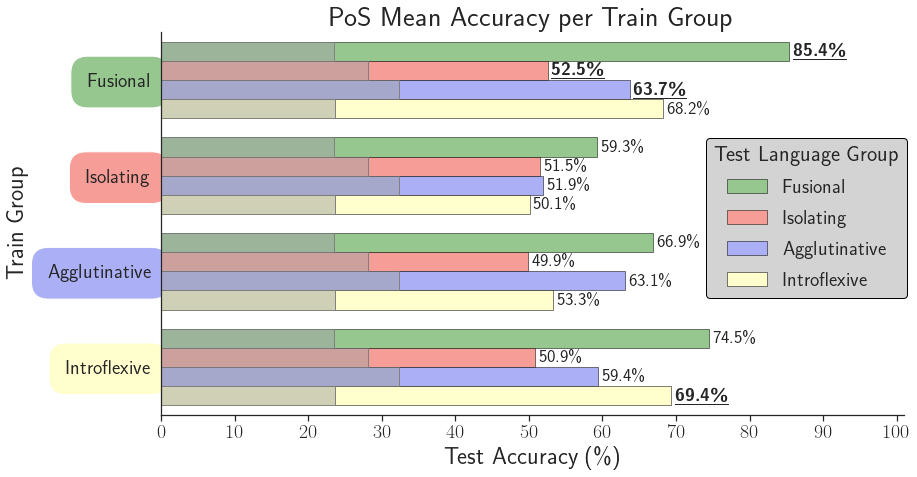

[A.3. Within- vs Cross-Language Performance](#A3)

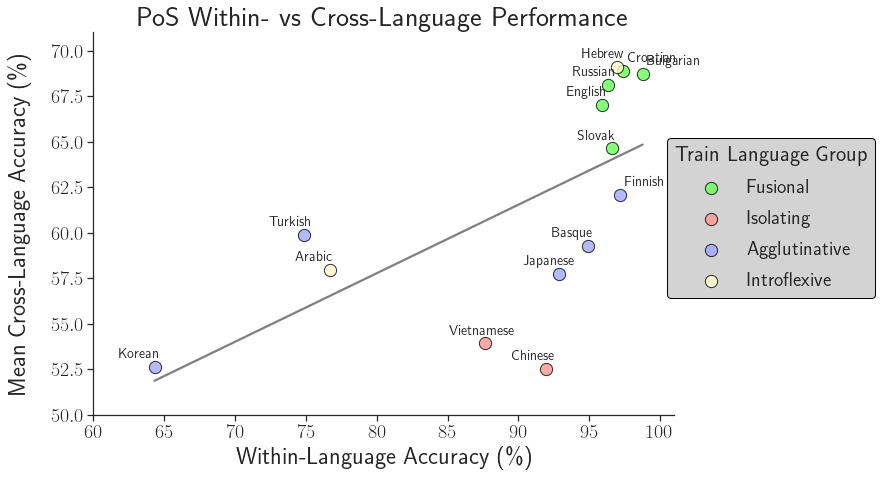

<hr>
<a id="A1"></a>

[Back to contents](#index)

### A.1. Lang vs Group Accuracy

In [2]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)

In [3]:
df = results["Accuracy"]["langvgroup"].iloc[:4]
df = df.drop([np.nan, "Thai", "Baseline"], axis=1)
df = df.set_index("Test\Train").T.applymap(lambda x: x*100).reset_index()
df = pd.melt(df, id_vars=df.columns[0], value_vars=df.columns[1:]).rename(columns={"index": "Train Language", 
                                                                                   "Test\Train": "Test Group",
                                                                                   "value": "Accuracy"})

In [18]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

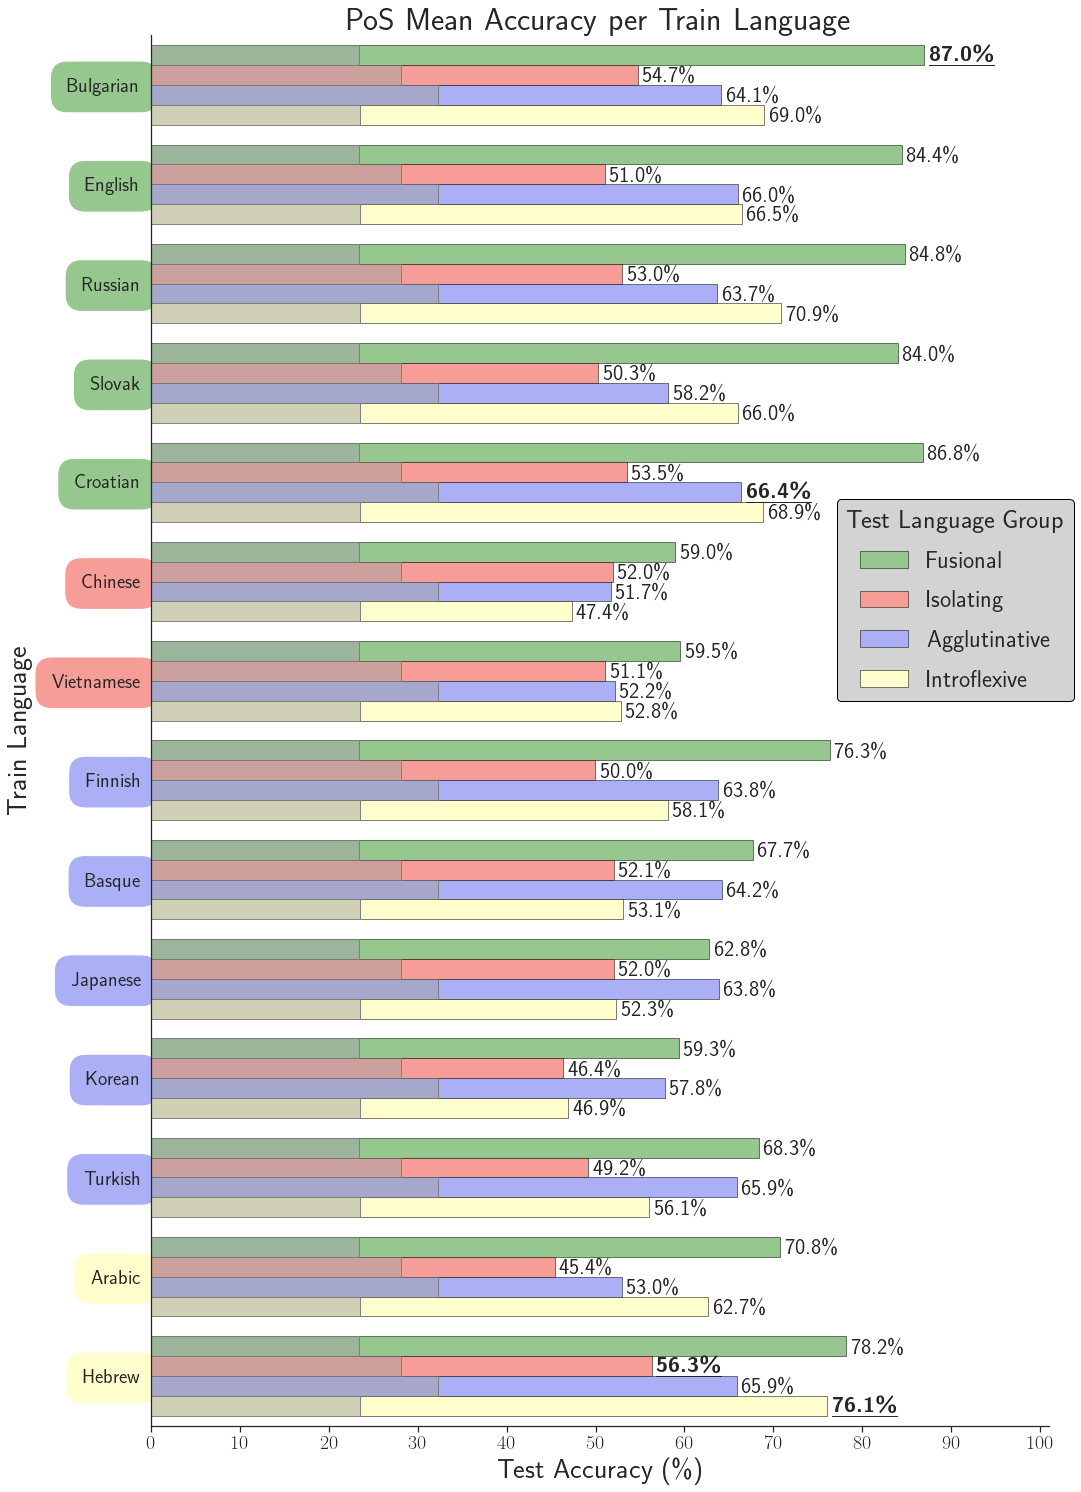

In [6]:
def scale_y(y, langs):
    return 1 - y / len(langs)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
label_colors = np.array([np.repeat(color, times).tolist() for color, times in zip(colors, [5, 2, 5, 2])]).sum()
extra_fontsize = 4

g = sns.catplot(
    data=df, kind="bar", x="Accuracy", y="Train Language", hue="Test Group",
    height=20, aspect=0.7, palette=colors, saturation=1, legend=False, edgecolor="black", linewidth=0.5
)

langs = df["Train Language"].unique().tolist()
test_maxs = df[["Test Group", "Accuracy"]].groupby("Test Group", sort=False).max().values.flatten()
baselines = results["Accuracy"]["langvgroup"].loc[:3, "Baseline"].values * 100

for lang in langs:
    values = df.loc[(df["Train Language"] == lang), "Accuracy"].values
    dy = np.arange(-0.3, 1, 0.2)
    for i, idx in enumerate(df.index[df["Train Language"] == lang]):
        if values[i] == test_maxs[i]:
            p = r"\textbf{{\underline{{{}}}}}".format("{:.1f}\%".format(values[i]))
            extra_dy = 0
        else:
            p = "{:.1f}\%".format(values[i])
            extra_dy = 0.025
        g.ax.text(values[i] + 0.5, langs.index(lang) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        bline = (scale_y(langs.index(lang) + 0.1 + 0.2 * (i + 1), langs), 
                 scale_y(langs.index(lang) + 0.1 + 0.2 * i, langs))
        bbar = patches.Rectangle((0, langs.index(lang) + dy[i] + 0.1), baselines[i], -0.2, 
                              fill=True, color="#a3a3a3", alpha=0.5, ec="grey", lw=0.5)
        g.ax.add_patch(bbar)
        g.ax.axvline(baselines[i], bline[0], bline[1], linewidth=1, color="grey", solid_capstyle="butt")
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.75, 0.675), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((0, 101))
plt.xticks(range(0, 101, 10))
plt.ylabel("Train Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Test Accuracy (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Mean Accuracy per Train Language", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_lang_vs_group_results_accuracy.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

<hr>
<a id="A2"></a>

[Back to contents](#index)

### A.2. Group vs Group Accuracy

In [7]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)

In [8]:
df = results["Accuracy"]["groupvgroup"].loc[:3, ["Test\Train", "Fusional", "Isolating", "Agglutinative", "Introflexive"]]
df = df.set_index("Test\Train").T.applymap(lambda x: x*100).reset_index()
df = pd.melt(df, id_vars=df.columns[0], value_vars=df.columns[1:]).rename(columns={"index": "Train Group", 
                                                                                   "Test\Train": "Test Group",
                                                                                   "value": "Accuracy"})

In [9]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

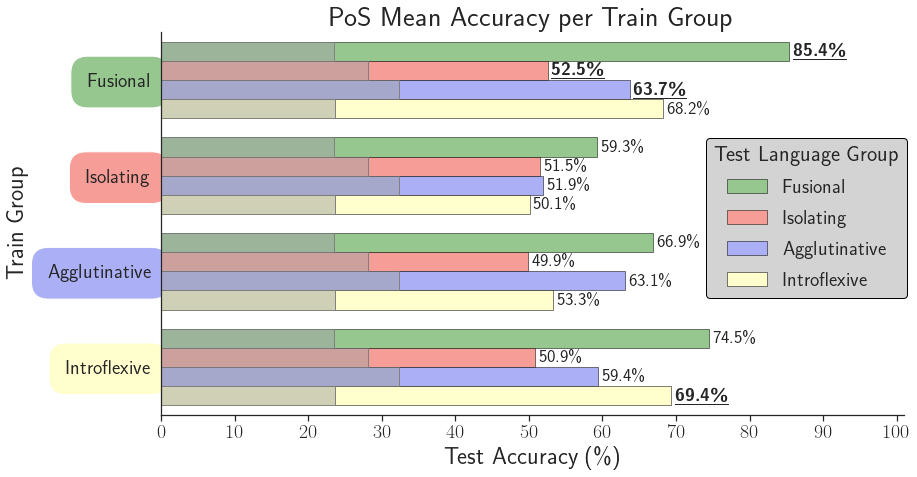

In [10]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
extra_fontsize = 0

g = sns.catplot(
    data=df, kind="bar", x="Accuracy", y="Train Group", hue="Test Group",
    height=6, aspect=2, palette=colors, saturation=1, legend=False, edgecolor="black", linewidth=0.5
)

groups = df["Train Group"].unique().tolist()
test_maxs = df[["Test Group", "Accuracy"]].groupby("Test Group", sort=False).max().values.flatten()
baselines = results["Accuracy"]["langvgroup"].loc[:3, "Baseline"].values * 100

for group in groups:
    values = df.loc[(df["Train Group"] == group), "Accuracy"].values
    dy = np.arange(-0.3, 1, 0.2)
    for i, idx in enumerate(df.index[df["Train Group"] == group]):
        if values[i] == test_maxs[i]:
            p = r"\textbf{{\underline{{{}}}}}".format("{:.1f}\%".format(values[i]))
        else:
            p = "{:.1f}\%".format(values[i])
        g.ax.text(values[i] + 0.5, groups.index(group) + dy[i], p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        bline = (scale_y(groups.index(group) + 0.1 + 0.2 * (i + 1), groups), 
                 scale_y(groups.index(group) + 0.1 + 0.2 * i, groups))
        bbar = patches.Rectangle((0, groups.index(group) + dy[i] + 0.1), baselines[i], -0.2, 
                              fill=True, color="#a3a3a3", alpha=0.5, ec="grey", lw=0.5)
        g.ax.add_patch(bbar)
        g.ax.axvline(baselines[i], bline[0], bline[1], linewidth=1, color="grey", solid_capstyle="butt")
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.72, 0.75), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.xlim((0, 101))
plt.xticks(range(0, 101, 10))
plt.ylabel("Train Group", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Test Accuracy (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Mean Accuracy per Train Group", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_group_vs_group_results_accuracy.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

<hr>
<a id="A3"></a>

[Back to contents](#index)

### A.3. Within- vs Cross-Language Performance

In [20]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)
df = results["Accuracy"]["langvlang"].drop("Thai", axis=1)

In [21]:
df = pd.melt(df.iloc[:15,:-1], id_vars=df.iloc[:15,:-1].columns[:2], 
             value_vars=df.iloc[:15,:-1].columns[2:]).rename(columns={"Test\Train": "Test",
                                                                      "variable": "Train",
                                                                      "value": "Accuracy"})
df["Accuracy"] = df["Accuracy"].astype(float) * 100

In [23]:
within_scores = df[df["Test"] == df["Train"]]

In [24]:
cross_scores = df.loc[~df.index.isin(within_scores.index)]

In [25]:
within_scores = within_scores.rename(columns={"Accuracy": "Accuracy-within"})
cross_scores = cross_scores.rename(columns={"Accuracy": "Accuracy-cross"})

In [26]:
within_vs_cross = pd.merge(within_scores.drop("Test", axis=1), cross_scores, on="Train", suffixes=("-train", "-test"))

In [27]:
within_vs_cross_avg = within_vs_cross[["Train", "Accuracy-within", "Accuracy-cross"]].groupby("Train", 
                                                                                              as_index=False, sort=False).mean()
within_vs_cross_avg.insert(0, "Group-train", within_scores["Group"].values)

It's actually more fair to average per group first

In [30]:
WvC_double_avg = within_vs_cross.groupby(by=["Train", "Group-test"], sort=False, 
                                         as_index=False).mean().groupby(by="Train", sort=False, as_index=False).mean()
WvC_double_avg.insert(0, "Group-train", within_scores["Group"].values)

In [32]:
pearsonr(x=WvC_double_avg["Accuracy-within"], y=WvC_double_avg["Accuracy-cross"])

(0.6422696510432844, 0.013258706438344672)

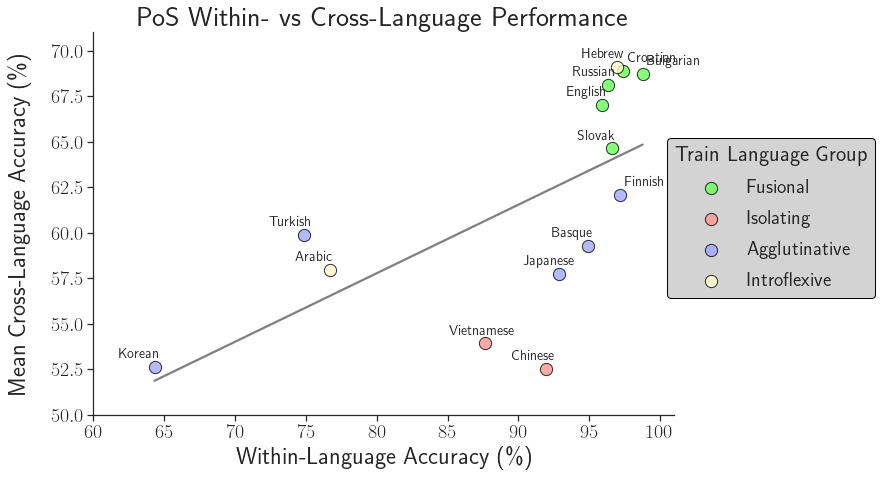

In [33]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="Accuracy-within", y="Accuracy-cross", data=WvC_double_avg, hue="Group-train", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="Accuracy-within", y="Accuracy-cross", data=WvC_double_avg, scatter=False, #ax=g.ax, 
            color="grey", ci=None)

for i, row in WvC_double_avg.iterrows():
    if row["Accuracy-within"] <= 97:
        dx = -2.5
    else:
        dx = 0.3
    plt.text(row["Accuracy-within"] + dx, row["Accuracy-cross"] + 0.5, row["Train"], fontsize=14)

plt.legend(title="Train Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.97, 0.75), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.ylim((50,71))
plt.xlim((60,101))
plt.ylabel("Mean Cross-Language Accuracy (\%)", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Within-Language Accuracy (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Within- vs Cross-Language Performance", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_within_vs_cross_accuracy.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()